<a href="https://colab.research.google.com/github/pedrojosefernandez1/RL_FCPSSL/blob/main/MetodosTabulares.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estudio del Comportamiento de Algoritmos de Aprendizaje por Refuerzo por Métodos Tabulares 

````
Author: Jaime Pujante Sáez
Email: jaime.pujantes@um.es

Author: Ricardo Javier Sendra Lázaro
Email: ricardojavier.sendral@um.es

Author: Pedro José Fernandez Campillo
Email: pedrojose.fernandez1@um.es
````

En este notebook, se analizará el comportamiento de distintos algoritmos de aprendizaje por refuerzo basados en métodos tabulares, tales como:
- **MonteCarlo**
- **SARSA**
- **Q-Learning**

El objetivo es evaluar su desempeño en un entorno del framework **Gymnasium**.
## Preparación del entorno
### 1. Clonación del repositorio e instalación de dependencias
Para comenzar, clonamos el repositorio con la implementación de los algoritmos y luego instalamos las dependencias necesarias:


In [ ]:
import os
from urllib.parse import urlparse

GITHUB_REPO_URL = "https://github.com/pedrojosefernandez1/RL_FCPSSL.git"
# Extraer usuario y nombre del repositorio automáticamente
def obtener_usuario_y_repo(url):
    path = urlparse(url).path.strip('/')
    parts = path.split('/')
    if len(parts) >= 2:
        return parts[0], parts[1]
    return None, None

GITHUB_USERNAME, GITHUB_REPO_NAME = obtener_usuario_y_repo(GITHUB_REPO_URL)
GITHUB_REPO_NAME = GITHUB_REPO_NAME.replace('.git', '')
if not GITHUB_USERNAME or not GITHUB_REPO_NAME:
    raise ValueError("URL del repositorio inválida. Asegúrate de que sea de GitHub y tenga el formato correcto.")

REPO_NAME = GITHUB_REPO_NAME  # Nombre de la carpeta después de clonar

# Clonar el repositorio si no existe
os.makedirs(REPO_NAME, exist_ok=True)
if not os.path.exists(os.path.join(REPO_NAME, ".git")):
    ! git clone {GITHUB_REPO_URL} {REPO_NAME}

# Verificar si existe un archivo requirements.txt para instalar dependencias
req_file = os.path.join(REPO_NAME, "requirements.txt")
if os.path.exists(req_file):
    ! pip install -r {req_file}

### 2. Importación de librerías necesarias
Una vez instaladas las dependencias, importamos las librerías requeridas para el análisis:

In [ ]:
import os
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import numpy as np
from tqdm import tqdm

In [ ]:


# --- Implementación de Tile Coding ---

class IHT:
    """Tabla hash de índices para tile coding."""
    def __init__(self, size):
        self.size = size
        self.dictionary = {}
        self.overfullCount = 0

    def getindex(self, obj, readonly=False):
        if obj in self.dictionary:
            return self.dictionary[obj]
        elif readonly:
            return None
        else:
            if len(self.dictionary) >= self.size:
                self.overfullCount += 1
                return hash(obj) % self.size
            else:
                index = len(self.dictionary)
                self.dictionary[obj] = index
                return index

def tiles(iht, num_tilings, floats):
    """
    Calcula los índices activados para un vector de entrada "floats" usando 'num_tilings'
    rejillas (tilings). Se aplica un pequeño desplazamiento en cada tiling.
    """
    qfloats = [int(np.floor(f * num_tilings)) for f in floats]
    tiles_indices = []
    for tiling in range(num_tilings):
        coords = [tiling]
        for f in qfloats:
            # Se suma el tiling como offset para desplazar cada rejilla ligeramente.
            coords.append((f + tiling) // num_tilings)
        tiles_indices.append(iht.getindex(tuple(coords)))
    return tiles_indices

class TileCodingFeatureExtractor:
    """
    Convierte un estado continuo en un vector de características disperso usando tile coding.
    
    Parámetros:
      - num_tilings: número de rejillas superpuestas.
      - low, high: límites inferior y superior para cada dimensión del estado.
      - iht_size: tamaño de la tabla hash (debe ser potencia de 2).
    """
    def __init__(self, num_tilings=8, low=None, high=None, iht_size=2048):
        self.num_tilings = num_tilings
        self.low = np.array(low)
        self.high = np.array(high)
        self.iht = IHT(iht_size)
        # Factor de escala para mapear cada dimensión al número de tilings.
        self.scale = self.num_tilings / (self.high - self.low)

    def __call__(self, state):
        state = np.array(state)
        # Escala el estado y lo desplaza para cada tiling.
        scaled_state = (state - self.low) * self.scale
        indices = tiles(self.iht, self.num_tilings, scaled_state)
        feature_vector = np.zeros(self.iht.size)
        feature_vector[indices] = 1  # Activa los índices correspondientes.
        return feature_vector

# --- Agente SARSA Semigradiente con Aproximación Lineal usando Tile Coding ---

class SarsaSemiGradientAgent:
    """
    Agente que utiliza la actualización SARSA semigradiente para aprender
    una función de valor aproximada con representaciones de tile coding.
    """
    def __init__(self, env, feature_extractor, alpha=0.05, gamma=0.99, epsilon=0.1):
        self.env = env
        self.feature_extractor = feature_extractor
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.nA = env.action_space.n
        # Se crean vectores de pesos (uno por acción) con dimensión igual a la salida del feature extractor.
        self.weights = np.zeros((self.nA, feature_extractor.iht.size))

    def get_Q(self, state):
        """Calcula los valores Q para cada acción dado un estado."""
        features = self.feature_extractor(state)
        Q_values = np.dot(self.weights, features)
        return Q_values

    def get_action(self, state):
        """Selecciona una acción usando política ε-greedy."""
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        Q_values = self.get_Q(state)
        return np.argmax(Q_values)

    def update(self, state, action, reward, next_state, next_action, done):
        """Realiza la actualización SARSA semigradiente."""
        features = self.feature_extractor(state)
        Q_current = np.dot(self.weights[action], features)
        Q_next = np.dot(self.weights[next_action], self.feature_extractor(next_state)) if not done else 0.0
        td_error = reward + self.gamma * Q_next - Q_current
        # Actualización de los pesos en la dirección del gradiente (multiplicado por features)
        self.weights[action] += self.alpha * td_error * features

    def setup_video_recording(self, render_interval=-1, video_path=None):
        """
        Configura la grabación de videos si se proporciona un directorio de almacenamiento.
        Args:
            render_interval (int, opcional): Frecuencia de grabación de episodios.
            video_path (str, opcional): Directorio donde almacenar videos.
        """
        if video_path:
            env_name = self.env.spec.id if self.env.spec else "UnknownEnv"
            env_dir = os.path.join(video_path, env_name)
            model_name = str(self).replace("=", "").replace(",", "").replace(" ", "_")
            model_dir = os.path.join(env_dir, model_name)
            os.makedirs(model_dir, exist_ok=True)
            # Se utiliza RecordVideo para envolver el ambiente
            self.env = RecordVideo(self.env, model_dir, episode_trigger=lambda episode: episode % render_interval == 0)

    def train(self, num_episodes=20000):
        """Entrena el agente y devuelve la lista de recompensas acumuladas por episodio."""

        self.episodes = []
        self.rewards = []
        for episode in tqdm(range(num_episodes)):
            state, _ = self.env.reset(seed=32)
            action = self.get_action(state)
            total_reward = 0
            done = False
            episode_data = []
            while not done:
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                next_action = self.get_action(next_state)
                self.update(state, action, reward, next_state, next_action, done)
                state = next_state
                action = next_action
                episode_data.append((state, action, reward))
                total_reward += reward
            if truncated:
                self.alpha = self.alpha/2
                self.epsilon = self.epsilon/2
            self.rewards.append(total_reward)
            self.episodes.append(episode_data)
        return self.rewards
    
    def stats(self):
        stats = {'episodes': self.episodes, 'rewards': self.rewards}
        return stats
    
    def __str__(self):
        """
        Devuelve una representación en cadena del agente con sus parámetros actuales.
        """
        return (f'Sarsa_Maestro(gamma={self.gamma}, alpha={self.alpha})')

# --- Optimización para el entorno CartPole-v1 de Gymnasium ---

def optimize_for_cartpole():
    """
    Configura el agente para el entorno "CartPole-v1".
    
    Consideraciones:
      1. El espacio de observación de CartPole-v1 tiene 4 dimensiones:
         [posición del carro, velocidad del carro, ángulo de la barra, velocidad angular].
      2. Algunos límites vienen definidos como infinitos. Para tile coding es útil
         definir límites realistas. Se establecen límites para la velocidad y velocidad angular.
      3. Se usan 16 tilings y un IHT de tamaño 2048 para capturar mejor la resolución
         del espacio de estados.
      4. Se ajusta el learning rate (alpha) y la tasa de exploración (epsilon).
    """
           
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    # Obtener límites del espacio de observación.
    low = env.observation_space.low.copy()
    high = env.observation_space.high.copy()
    # Ajustar límites para las dimensiones con valores infinitos:
    # Por ejemplo, para la velocidad del carro y la velocidad angular se pueden usar [-3, 3]
    low[1] = -3.0
    low[3] = -3.0
    high[1] = 3.0
    high[3] = 3.0

    # Crear el extractor de características con más tilings para mayor resolución.
    feature_extractor = TileCodingFeatureExtractor(num_tilings=16, low=low, high=high, iht_size=2048)
    agent = SarsaSemiGradientAgent(env, feature_extractor, alpha=0.05, gamma=0.99, epsilon=0.1)
    video_directory = "./videos"  # Directorio donde se almacenarán los videos
    agent.setup_video_recording(render_interval=100, video_path=video_directory)
    rewards = agent.train(num_episodes=1000)
    return agent

agent = optimize_for_cartpole()

 40%|███▉      | 399/1000 [00:14<00:24, 24.78it/s]

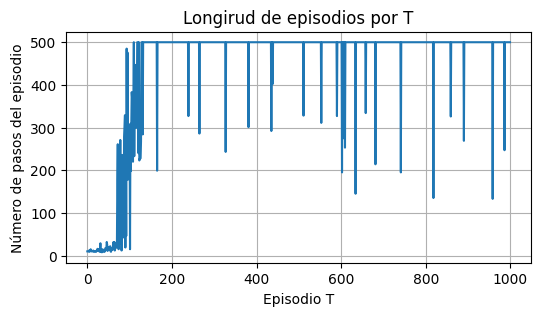

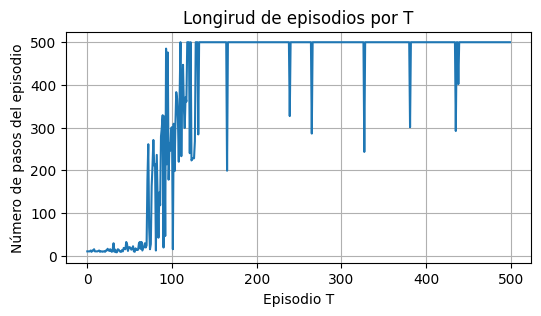

In [32]:
import matplotlib.pyplot as plt
def plot_len_episodes(episodes):
  # Creamos una lista de índices para el eje x
  # Creamos el gráfico
  plt.figure(figsize=(6, 3))
  plt.plot(    [len(episode) for episode in episodes]
)
  # Añadimos título y etiquetas
  plt.title('Longirud de episodios por T')
  plt.xlabel('Episodio T')
  plt.ylabel('Número de pasos del episodio')
  # Mostramos el gráfico
  plt.grid(True)
  plt.show()

plot_len_episodes(agent.stats()["episodes"])
plot_len_episodes(agent.stats()["episodes"][0:500])

In [ ]:
import os
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import numpy as np
from tqdm import tqdm

class SarsaAgent:

    def __init__(self, env, alpha=0.01, gamma=0.99, epsilon=0.1):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.n_actions = env.action_space.n
        # Obtenemos un estado de ejemplo para definir la dimensión de las características.
        dummy_state, _ = self.env.reset()
        state_features_dim = len(np.concatenate([np.array([1]), np.array(dummy_state)]))
        self.w_dim = state_features_dim * self.n_actions
        self.w = np.zeros(self.w_dim)

    def feature_vector(self, state, action):
        """
        Crea un vector de características combinando un sesgo, el estado y una codificación one-hot de la acción.
        """
        state = np.array(state)
        bias = np.array([1])
        state_features = np.concatenate([bias, state])
        # Codificación one-hot para la acción
        action_vector = np.zeros(self.n_actions)
        action_vector[action] = 1
        # Producto de Kronecker para combinar ambas informaciones
        return np.kron(action_vector, state_features)

    def Q(self, state, action):
        """
        Aproximación lineal de Q(s,a) = w^T * φ(s,a)
        """
        phi = self.feature_vector(state, action)
        return np.dot(self.w, phi)

    def epsilon_greedy_policy(self, state):
        """
        Política ε-greedy: con probabilidad epsilon elige acción al azar, de lo contrario la acción con mayor Q.
        """
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.n_actions)
        else:
            q_values = [self.Q(state, a) for a in range(self.n_actions)]
            return np.argmax(q_values)

    def setup_video_recording(self, render_interval=-1, video_path=None):
        """
        Configura la grabación de videos si se proporciona un directorio de almacenamiento.
        Args:
            render_interval (int, opcional): Frecuencia de grabación de episodios.
            video_path (str, opcional): Directorio donde almacenar videos.
        """
        if video_path:
            env_name = self.env.spec.id if self.env.spec else "UnknownEnv"
            env_dir = os.path.join(video_path, env_name)
            model_name = str(self).replace("=", "").replace(",", "").replace(" ", "_")
            model_dir = os.path.join(env_dir, model_name)
            os.makedirs(model_dir, exist_ok=True)
            # Se utiliza RecordVideo para envolver el ambiente
            self.env = RecordVideo(self.env, model_dir, episode_trigger=lambda episode: episode % render_interval == 0)

    def train(self, n_episodes):
        """
        Entrena al agente utilizando el algoritmo SARSA semi-gradiente.
        """
        for episode in tqdm(range(n_episodes)):
            state, _ = self.env.reset()
            action = self.epsilon_greedy_policy(state)
            done = False
            while not done:
                next_state, reward, done, truncated, info = self.env.step(action)
                next_action = self.epsilon_greedy_policy(next_state)
                # Cálculo del error TD
                delta = reward + self.gamma * self.Q(next_state, next_action) - self.Q(state, action)
                # Actualización semi-gradiente
                self.w += self.alpha * delta * self.feature_vector(state, action)
                state = next_state
                action = next_action

        print("Entrenamiento completado.")

    def __str__(self):
        """
        Devuelve una representación en cadena del agente con sus parámetros actuales.
        """
        return (f'Sarsa_Maestro(gamma={self.gamma}, alpha={self.alpha})')

    def __name__(self):
        return "Sarsa_Maestro"

# Configuración del ambiente
env = gym.make('CartPole-v1', render_mode='rgb_array')

# Inicialización del agente
agent = SarsaAgent(env, alpha=0.05, gamma=0.99, epsilon=0.1)

# Configurar la grabación de video (se grabará cada 50 episodios)
video_directory = "./videos"  # Directorio donde se almacenarán los videos
agent.setup_video_recording(render_interval=1000, video_path=video_directory)

# Entrenar al agente por 500 episodios
agent.train(n_episodes=10000)


 50%|█████     | 5032/10000 [00:08<00:10, 465.01it/s]C:\Users\Pedro\AppData\Local\Temp\ipykernel_18268\4120751077.py:79: RuntimeWarning: invalid value encountered in scalar subtract
  delta = reward + self.gamma * self.Q(next_state, next_action) - self.Q(state, action)
100%|██████████| 10000/10000 [00:16<00:00, 592.43it/s]

Entrenamiento completado.
